In [23]:
import pandas as pd #
import numpy as np
from joblib import load
from sklearn.decomposition import PCA
from scipy.spatial.distance import mahalanobis
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import seaborn as sns

#crit_thresh = -0.080239
#warn_thresh = -0.030199
crit_thresh = -0.084337
warn_thresh = -0.036689


# Load Isolation Forest model and scaler
scaler = load('./model/iso_scaler2.joblib')
iso_model = load('./model/iso_model2.joblib')

# Load datasets
df_val = pd.read_excel("./../../data/test2.xlsx")
df_val = df_val.sort_values('timestamp').reset_index(drop=True)

In [24]:
df_val['label'] = df_val['label'].fillna('Normal')
df_val

,timestamp,devID,soil,rain,temp,humi,geo,label
0,2025-07-24T17:10:00,101,48.73,0.00,30.31,74.72,3.46,Normal
1,2025-07-24T17:10:10,101,49.25,0.00,29.89,75.31,5.21,Normal
2,2025-07-24T17:10:20,101,48.19,0.00,30.42,74.68,4.19,Normal
3,2025-07-24T17:10:30,101,48.58,0.00,29.68,75.95,3.93,Normal
4,2025-07-24T17:10:40,101,47.88,0.00,30.15,75.52,5.88,Normal
...,...,...,...,...,...,...,...,...
188,2025-07-24T17:41:20,101,78.48,38.11,27.98,69.70,13.52,critical
189,2025-07-24T17:41:30,101,78.89,30.21,27.96,69.30,27.42,critical
190,2025-07-24T17:41:40,101,79.31,36.21,27.94,68.90,13.13,critical
191,2025-07-24T17:41:50,101,79.73,34.84,27.92,68.50,11.75,critical


In [25]:
#df_val  = pd.concat([df1, df2], ignore_index=True)
df_val.describe()

,devID,soil,rain,temp,humi,geo
count,193.0,193.000000,193.000000,193.000000,193.000000,193.000000
mean,101.0,54.799637,13.220622,29.487461,77.332746,10.371347
std,0.0,9.739599,16.627213,0.734815,4.816547,8.323587
min,101.0,47.520000,0.000000,27.890000,68.100000,3.010000
25%,101.0,48.390000,0.000000,28.930000,74.920000,4.350000
50%,101.0,49.030000,0.000000,29.680000,75.640000,5.430000
75%,101.0,60.140000,33.160000,30.080000,77.300000,13.750000
max,101.0,80.140000,39.840000,30.490000,91.700000,29.980000


In [26]:
print(df_val['label'].value_counts())

label
Normal      115
critical     70
warning       8
Name: count, dtype: int64


## Threshold

In [27]:
# แปลง timestamp เป็น datetime หากยังไม่ได้แปลง
df_val['timestamp'] = pd.to_datetime(df_val['timestamp'])

# สร้างคอลัมน์ hour
df_val['hour'] = df_val['timestamp'].dt.hour

# สร้าง features
feature_cols = ['soil', 'rain', 'temp', 'humi', 'geo', 'hour']
X_val = df_val[feature_cols].values
X_val_scaled = scaler.transform(X_val)

# คำนวณ anomaly score และจัดระดับความเสี่ยง
df_val['anomaly_score'] = iso_model.decision_function(X_val_scaled)


#crit_thresh = np.percentile(df_val['anomaly_score'], 0.25)
#warn_thresh = np.percentile(df_val['anomaly_score'], 0.75)

def classify_risk(score):
    if score < crit_thresh:
        return "Critical"
    elif score < warn_thresh:
        return "Warning"
    else:
        return "Normal"

df_val['predicted_risk'] = df_val['anomaly_score'].apply(classify_risk)
print("Risk levels ('Critical', 'Warning', 'Normal') assigned based on anomaly scores.")

print("\nPredicted Risk Distribution:")
print(df_val['predicted_risk'].value_counts())

print("\nLabel Distribution:")
print(df_val['label'].value_counts())

#print("crit_thresh:", np.percentile(df_val['anomaly_score'], 0.4))
#print("warn_thresh:", np.percentile(df_val['anomaly_score'], 1))

Risk levels ('Critical', 'Warning', 'Normal') assigned based on anomaly scores.

Predicted Risk Distribution:
predicted_risk
Normal      115
Critical     66
Warning      12
Name: count, dtype: int64

Label Distribution:
label
Normal      115
critical     70
warning       8
Name: count, dtype: int64


In [28]:
critical_group = df_val[df_val['anomaly_score'] < crit_thresh]
print("critical_group")
print(critical_group[feature_cols].describe())

critical_group
            soil       rain       temp       humi        geo  hour
count  66.000000  66.000000  66.000000  66.000000  66.000000  66.0
mean   66.595303  35.082727  28.596515  80.552727  20.224848  17.0
std     8.009521   2.737711   0.415631   7.013656   6.650098   0.0
min    52.640000  30.210000  27.890000  68.100000  10.600000  17.0
25%    59.832500  32.695000  28.245000  74.600000  13.610000  17.0
50%    66.600000  35.055000  28.595000  81.100000  21.830000  17.0
75%    73.375000  37.360000  28.945000  86.620000  27.045000  17.0
max    80.140000  39.840000  29.320000  91.700000  29.980000  17.0


In [29]:
warn_group = df_val[(df_val['anomaly_score'] < warn_thresh) & (df_val['anomaly_score'] >= crit_thresh) ]
print("warn_group")
print(warn_group[feature_cols].describe())

warn_group
            soil       rain       temp       humi        geo  hour
count  12.000000  12.000000  12.000000  12.000000  12.000000  12.0
mean   49.881667  18.393333  29.488333  78.179167  11.912500  17.0
std     1.850070   9.507977   0.166123   2.945652   1.448549   0.0
min    47.560000  10.500000  29.130000  74.670000   9.600000  17.0
25%    48.247500  11.525000  29.412500  76.292500  11.022500  17.0
50%    49.855000  12.200000  29.555000  77.035000  11.825000  17.0
75%    51.247500  26.250000  29.570000  80.045000  12.850000  17.0
max    53.060000  35.000000  29.700000  84.140000  14.070000  17.0


In [30]:
normal_group = df_val[df_val['anomaly_score'] >= warn_thresh]
print("normal_group")
print(normal_group[feature_cols].describe())

normal_group
             soil        rain        temp        humi         geo   hour
count  115.000000  115.000000  115.000000  115.000000  115.000000  115.0
mean    48.543130    0.133913   29.998696   75.396435    4.555478   17.0
std      0.518497    0.581270    0.291582    0.571813    0.828214    0.0
min     47.520000    0.000000   29.210000   74.150000    3.010000   17.0
25%     48.160000    0.000000   29.800000   74.920000    3.850000   17.0
50%     48.520000    0.000000   30.010000   75.410000    4.640000   17.0
75%     48.905000    0.000000   30.220000   75.850000    5.215000   17.0
max     49.490000    3.200000   30.490000   76.510000    5.920000   17.0


C:\Users\ahmad\AppData\Local\Temp\ipykernel_21772\2053204387.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_val, x='predicted_risk', order=['Normal', 'Warning', 'Critical'], palette='Set2')


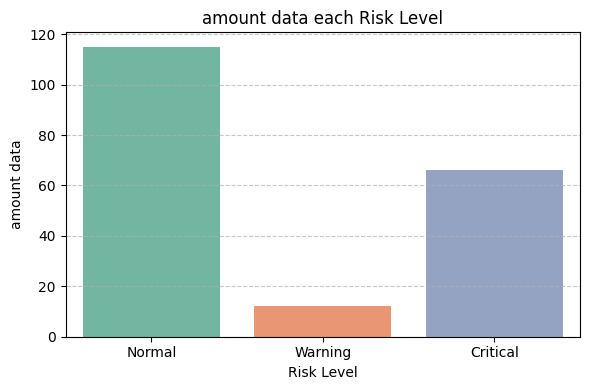

In [31]:

plt.figure(figsize=(6, 4))
sns.countplot(data=df_val, x='predicted_risk', order=['Normal', 'Warning', 'Critical'], palette='Set2')

plt.title('amount data each Risk Level')
plt.xlabel('Risk Level')
plt.ylabel('amount data')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Distribution of Anomaly Scores

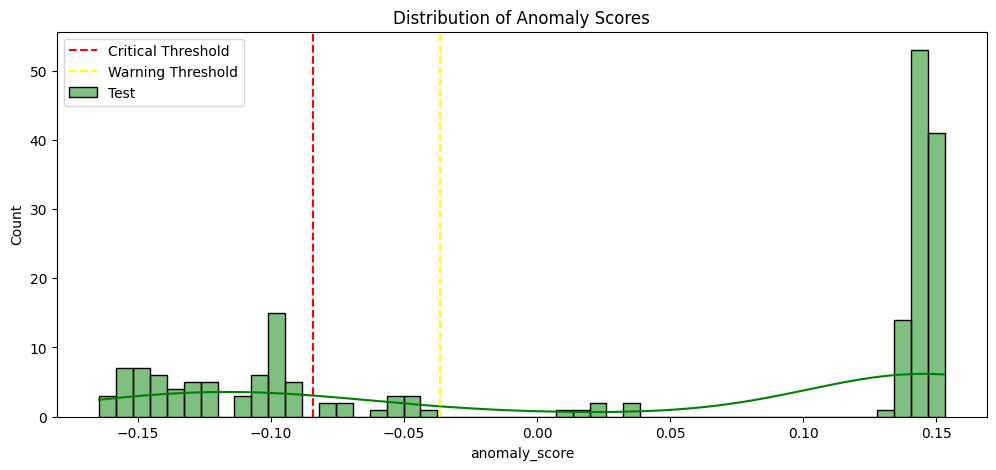

In [32]:
plt.figure(figsize=(12,5))
sns.histplot(df_val['anomaly_score'], bins=50, kde=True, color='green', label='Test')
plt.axvline(crit_thresh, color='red', linestyle='--', label='Critical Threshold')
plt.axvline(warn_thresh, color='yellow', linestyle='--', label='Warning Threshold')
plt.legend()
plt.title('Distribution of Anomaly Scores')
plt.show()



## PCA

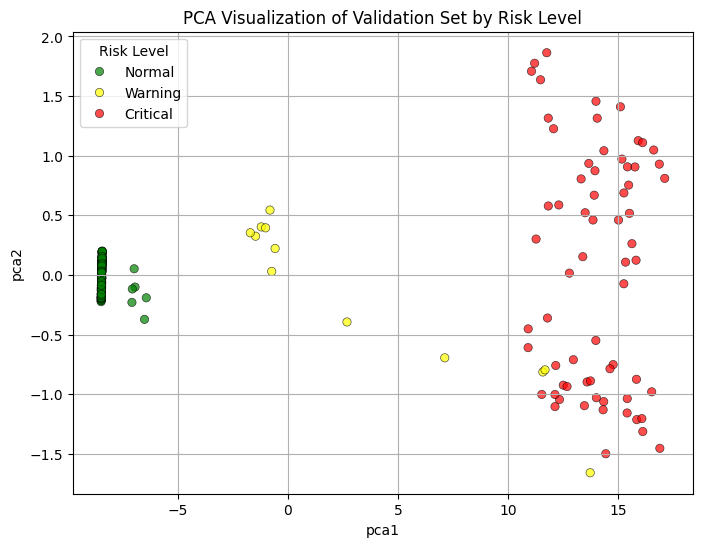

In [33]:
# Fit PCA
pca = PCA(n_components=2)
X_val_pca = pca.fit_transform(X_val_scaled)

# เพิ่มค่า PCA กลับเข้า df_val
df_val['pca1'] = X_val_pca[:, 0]
df_val['pca2'] = X_val_pca[:, 1]

# Map สีแบบกำหนดเอง
custom_palette = {
    'Normal': 'green',
    'Warning': 'yellow',
    'Critical': 'red'
}

# วาดกราฟ
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_val,
    x='pca1', y='pca2',
    hue='predicted_risk',
    palette=custom_palette,
    alpha=0.7,
    edgecolor='black'
)
plt.title('PCA Visualization of Validation Set by Risk Level')
plt.grid(True)
plt.legend(title='Risk Level')
plt.show()

In [34]:
print("\n== Mean Feature Values by Risk Level ==")
print(df_val.groupby('predicted_risk')[feature_cols].mean())


== Mean Feature Values by Risk Level ==
                     soil       rain       temp       humi        geo  hour
predicted_risk                                                             
Critical        66.595303  35.082727  28.596515  80.552727  20.224848  17.0
Normal          48.543130   0.133913  29.998696  75.396435   4.555478  17.0
Warning         49.881667  18.393333  29.488333  78.179167  11.912500  17.0


In [35]:
print("\n== Risk Level ==")
print(df_val['predicted_risk'].value_counts())


== Risk Level ==
predicted_risk
Normal      115
Critical     66
Warning      12
Name: count, dtype: int64


## histogram

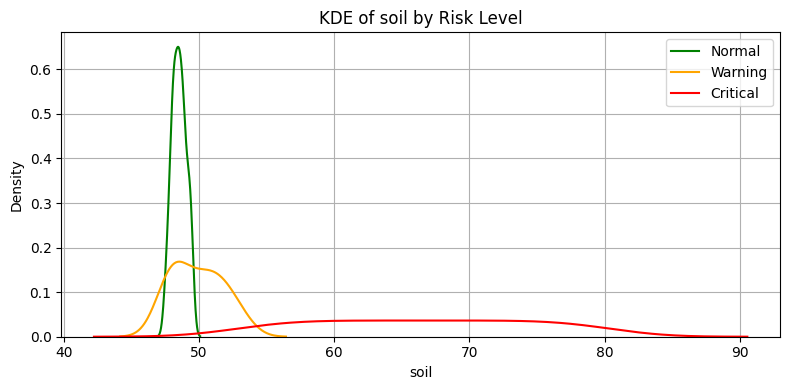

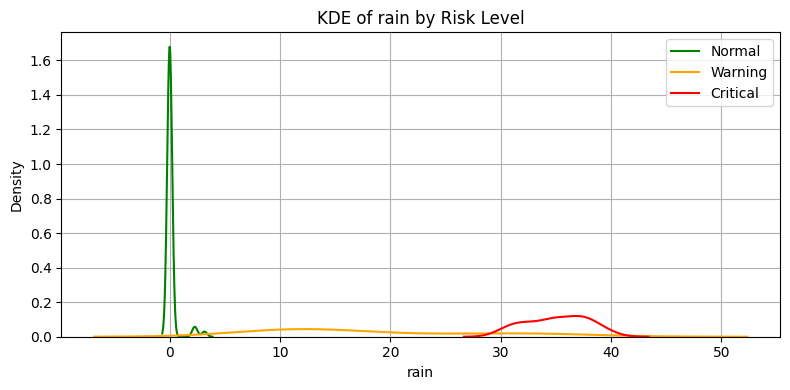

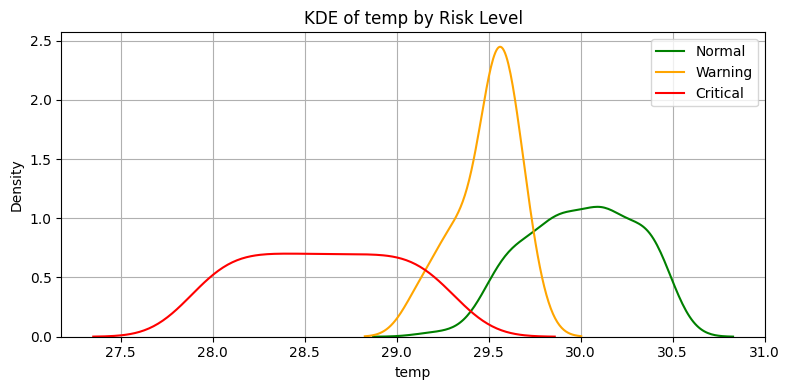

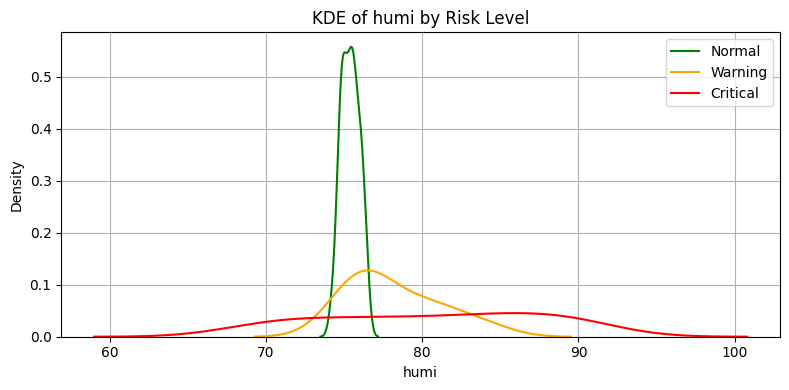

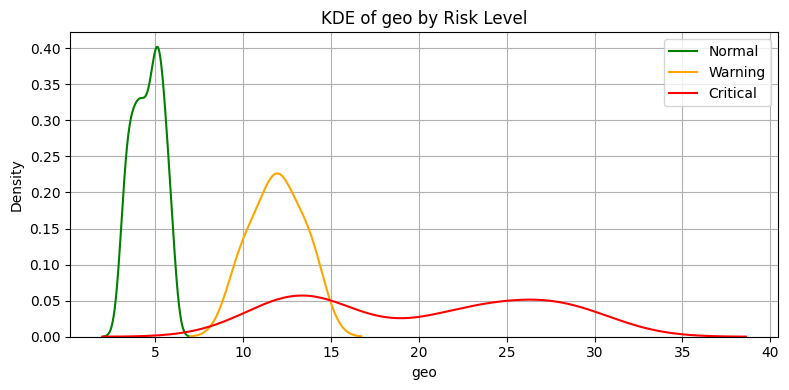

C:\Users\ahmad\AppData\Local\Temp\ipykernel_21772\1786158277.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df_val[df_val['predicted_risk'] == 'Normal'][col], label='Normal', color='green')
C:\Users\ahmad\AppData\Local\Temp\ipykernel_21772\1786158277.py:4: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df_val[df_val['predicted_risk'] == 'Warning'][col], label='Warning', color='orange')
C:\Users\ahmad\AppData\Local\Temp\ipykernel_21772\1786158277.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df_val[df_val['predicted_risk'] == 'Critical'][col], label='Critical', color='red')
C:\Users\ahmad\AppData\Local\Temp\ipykernel_21772\1786158277.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label 

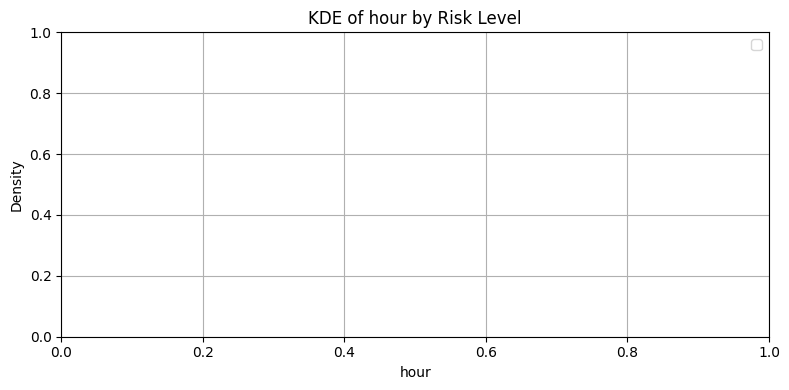

In [36]:
for col in feature_cols:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(df_val[df_val['predicted_risk'] == 'Normal'][col], label='Normal', color='green')
    sns.kdeplot(df_val[df_val['predicted_risk'] == 'Warning'][col], label='Warning', color='orange')
    sns.kdeplot(df_val[df_val['predicted_risk'] == 'Critical'][col], label='Critical', color='red')
    plt.title(f"KDE of {col} by Risk Level")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Box Plot feature by risk

C:\Users\ahmad\AppData\Local\Temp\ipykernel_21772\564551364.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\ahmad\AppData\Local\Temp\ipykernel_21772\564551364.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\ahmad\AppData\Local\Temp\ipykernel_21772\564551364.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\ahmad\AppData\Local\Temp\ipykernel_21772\564551364.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and 

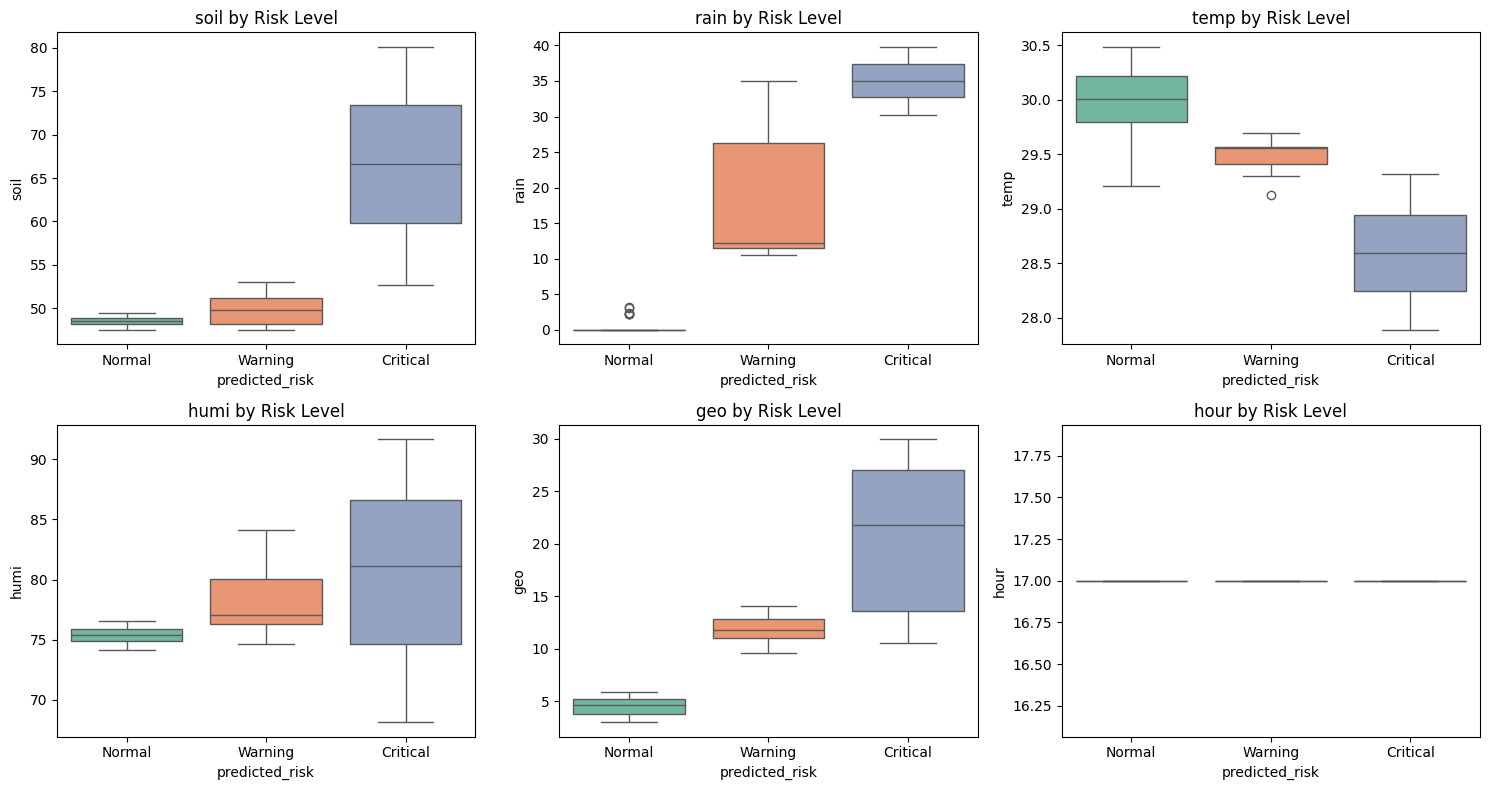

In [37]:
plt.figure(figsize=(15, 8))
for i, col in enumerate(feature_cols):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(
        x='predicted_risk',
        y=col,
        data=df_val,
        order=['Normal', 'Warning', 'Critical'],  # 🔧 fix order here
        palette='Set2'
    )
    plt.title(f'{col} by Risk Level')
plt.tight_layout()
plt.show()


## Time Series

In [38]:
df_val['timestamp'].min()

Timestamp('2025-07-24 17:10:00')

In [39]:
df_val['timestamp'].max()

Timestamp('2025-07-24 17:42:00')

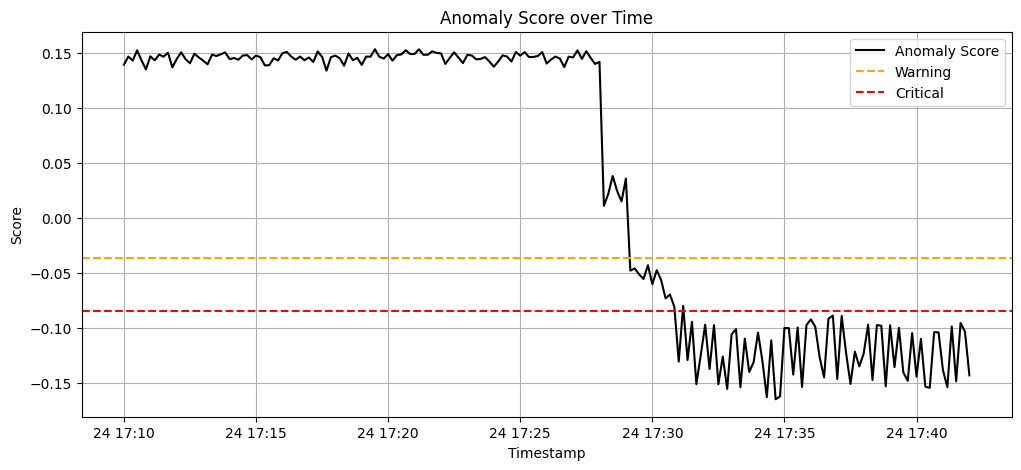

In [40]:
if 'timestamp' in df_val.columns:
    df_val['timestamp'] = pd.to_datetime(df_val['timestamp'])
    df_val_sorted = df_val.sort_values('timestamp')

    plt.figure(figsize=(12,5))
    plt.plot(df_val_sorted['timestamp'], df_val_sorted['anomaly_score'], color='black', label='Anomaly Score')
    plt.axhline(warn_thresh, color='orange', linestyle='--', label='Warning')
    plt.axhline(crit_thresh, color='red', linestyle='--', label='Critical')
    plt.title('Anomaly Score over Time')
    plt.xlabel('Timestamp')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()

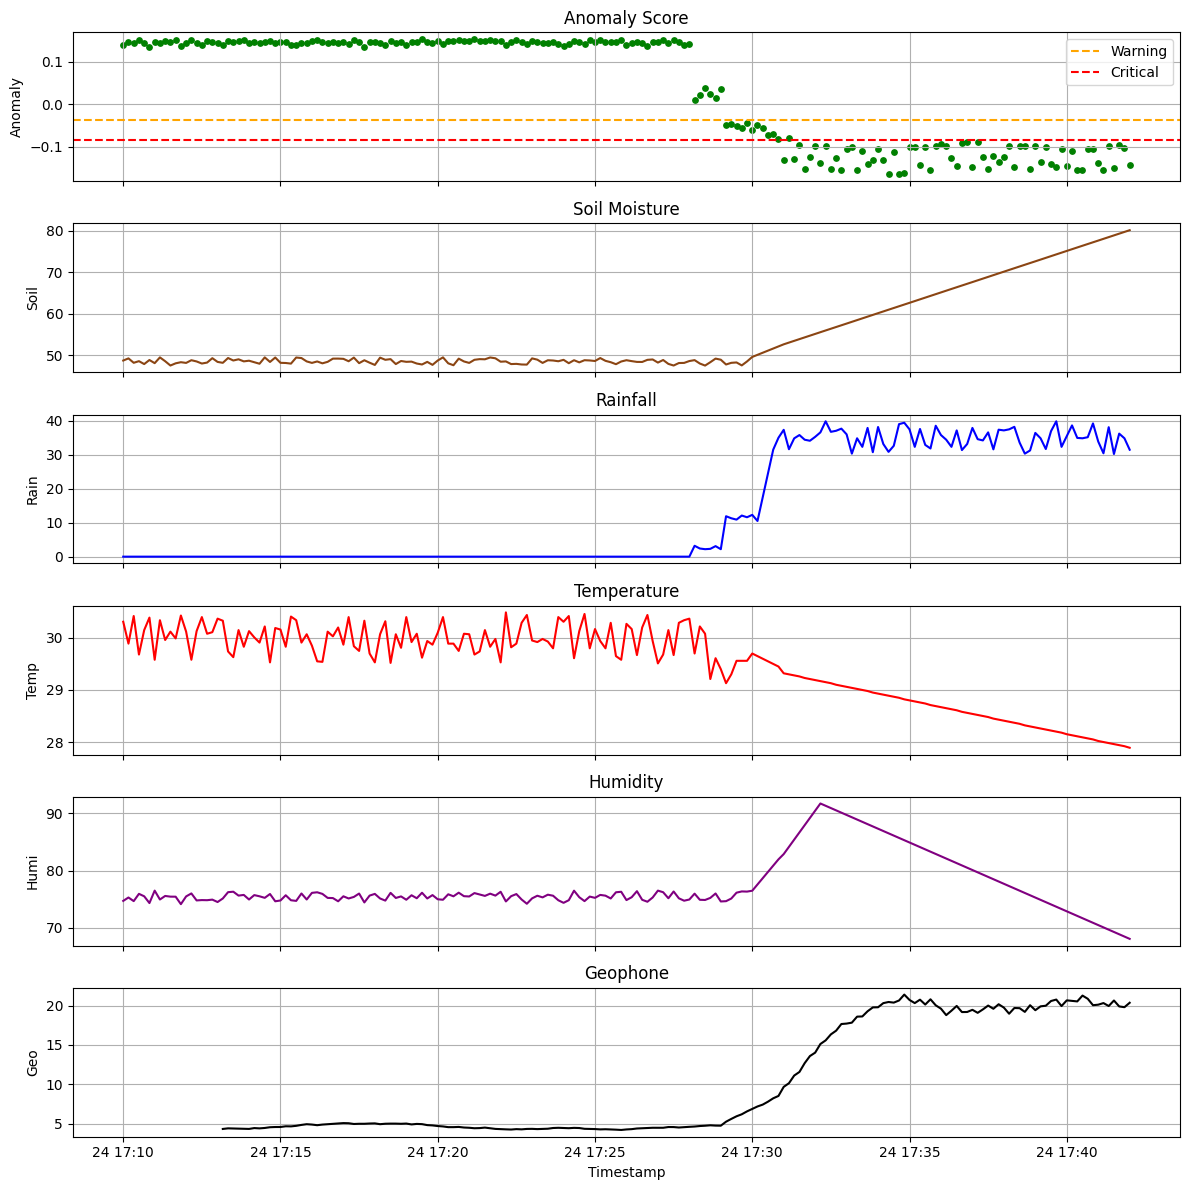

In [41]:
df_val['timestamp'] = pd.to_datetime(df_val['timestamp'])
df_dev = df_val.set_index('timestamp').sort_index()
df_range = df_dev.loc["2025-07-24":"2025-07-24"]

# สร้าง subplot 6 แถว
fig, axs = plt.subplots(6, 1, figsize=(12, 12), sharex=True)

# Plot 1: Anomaly Score
axs[0].scatter(df_range.index, df_range['anomaly_score'], color='green', s=15)
axs[0].axhline(y=warn_thresh, color='orange', linestyle='--', label='Warning')
axs[0].axhline(y=crit_thresh, color='red', linestyle='--', label='Critical')
axs[0].set_ylabel("Anomaly")
axs[0].set_title("Anomaly Score")
axs[0].legend()
axs[0].grid(True)

# Plot 2: Soil
axs[1].plot(df_range.index, df_range['soil'], color='saddlebrown')
axs[1].set_ylabel("Soil")
axs[1].set_title("Soil Moisture")
axs[1].grid(True)

# Plot 3: Rain
axs[2].plot(df_range.index, df_range['rain'], color='blue')
axs[2].set_ylabel("Rain")
axs[2].set_title("Rainfall")
axs[2].grid(True)

# Plot 4: Temp
axs[3].plot(df_range.index, df_range['temp'], color='red')
axs[3].set_ylabel("Temp")
axs[3].set_title("Temperature")
axs[3].grid(True)

# Plot 5: Humi
axs[4].plot(df_range.index, df_range['humi'], color='purple')
axs[4].set_ylabel("Humi")
axs[4].set_title("Humidity")
axs[4].grid(True)

window_size = 20  # ลองปรับค่าตามความเหมาะสม เช่น 10, 50, 100
smoothed_geo = df_range['geo'].rolling(window=window_size).mean()

axs[5].plot(df_range.index, smoothed_geo, color='black')
axs[5].set_ylabel("Geo")
axs[5].set_title("Geophone")
axs[5].grid(True)

plt.xlabel("Timestamp")
plt.tight_layout()
plt.show()


# F1-score

In [42]:

# --- 4. Prepare True Labels for Multi-Class Evaluation ---

df_val['true_label_mapped_multi'] = df_val['label'].replace({
    'critical': 'Critical', 
    'normal': 'Normal',
    'Normal': 'Normal',
    'warning':'Warning'
})

label_order = ['Critical', 'Warning', 'Normal']

df_val_filtered_multi_eval = df_val[df_val['true_label_mapped_multi'].isin(label_order)].copy()

y_true_multi = df_val_filtered_multi_eval['true_label_mapped_multi']
y_pred_multi = df_val_filtered_multi_eval['predicted_risk']

print("\nTrue Label Mapping for Multi-Class Evaluation:")
print(y_true_multi.value_counts())
print("\nPredicted Risk Label Distribution (for Multi-Class F1-score):")
print(y_pred_multi.value_counts())



True Label Mapping for Multi-Class Evaluation:
true_label_mapped_multi
Normal      115
Critical     70
Warning       8
Name: count, dtype: int64

Predicted Risk Label Distribution (for Multi-Class F1-score):
predicted_risk
Normal      115
Critical     66
Warning      12
Name: count, dtype: int64


In [43]:
# --- 5. Calculate and Print Multi-Class F1-score and other metrics ---
print("\n--- Multi-Class Model Evaluation (Normal, Warning, Critical) ---")

# For multi-class F1-score, we usually use 'weighted' or 'macro' average
# 'weighted' accounts for class imbalance
# 'macro' treats all classes equally
# 'None' gives F1-score for each class separately
f1_weighted = f1_score(y_true_multi, y_pred_multi, average='weighted', labels=label_order, zero_division=0)
f1_macro = f1_score(y_true_multi, y_pred_multi, average='macro', labels=label_order, zero_division=0)
f1_per_class = f1_score(y_true_multi, y_pred_multi, average=None, labels=label_order, zero_division=0)

print(f"\nWeighted F1-score: {f1_weighted:.4f}")
print(f"Macro F1-score: {f1_macro:.4f}")
print(f"F1-score per class ({label_order}): {f1_per_class}")


# Full classification report for multi-class
print("\nClassification Report (Multi-Class):")
# target_names should match the order of labels in y_true_multi and y_pred_multi
print(classification_report(y_true_multi, y_pred_multi, labels=label_order, target_names=label_order, zero_division=0))


# Confusion Matrix for multi-class
cm_multi = confusion_matrix(y_true_multi, y_pred_multi, labels=label_order)
print("\nConfusion Matrix (Multi-Class):")
print(cm_multi)



--- Multi-Class Model Evaluation (Normal, Warning, Critical) ---

Weighted F1-score: 0.9810
Macro F1-score: 0.9235
F1-score per class (['Critical', 'Warning', 'Normal']): [0.97058824 0.8        1.        ]

Classification Report (Multi-Class):
              precision    recall  f1-score   support

    Critical       1.00      0.94      0.97        70
     Warning       0.67      1.00      0.80         8
      Normal       1.00      1.00      1.00       115

    accuracy                           0.98       193
   macro avg       0.89      0.98      0.92       193
weighted avg       0.99      0.98      0.98       193


Confusion Matrix (Multi-Class):
[[ 66   4   0]
 [  0   8   0]
 [  0   0 115]]


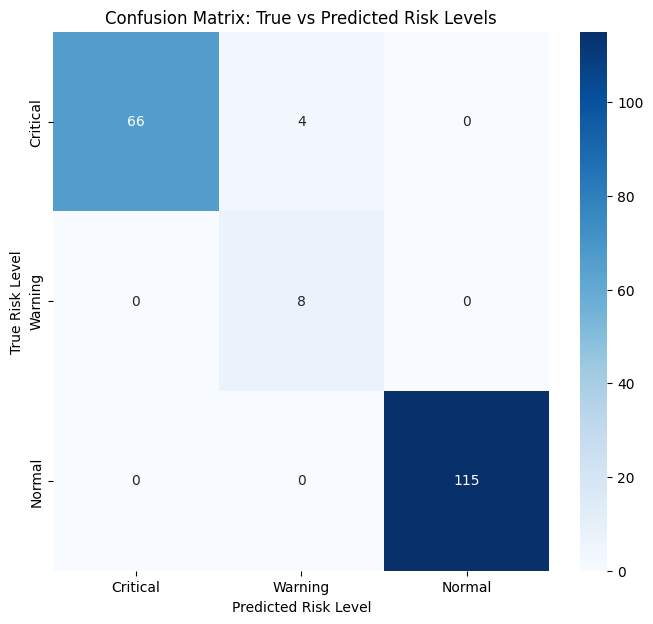

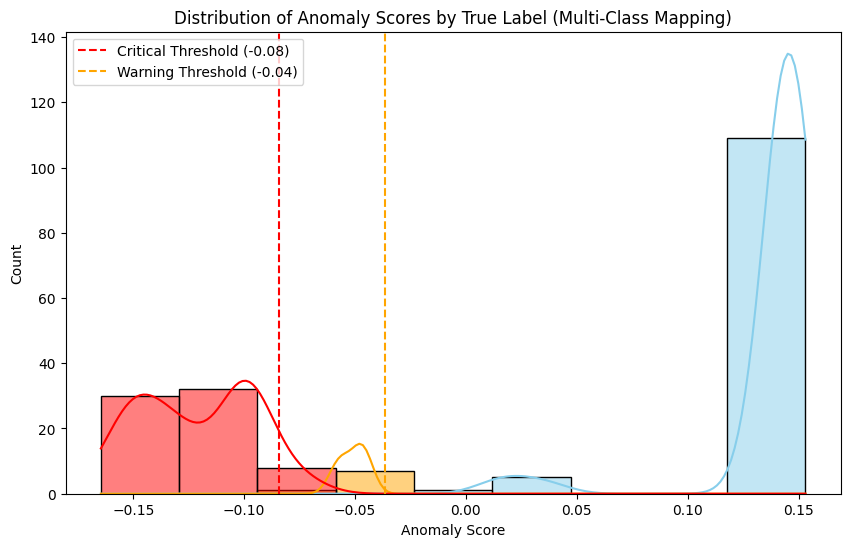

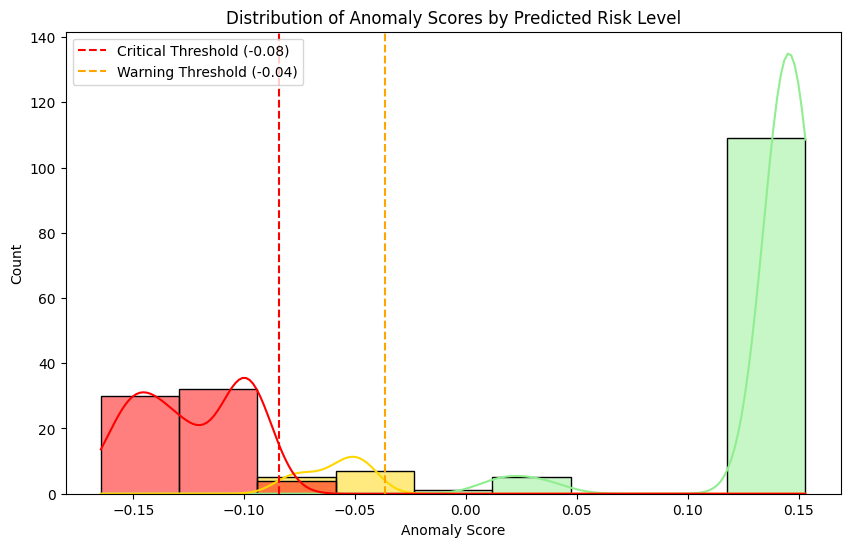

In [44]:
# Visualize Confusion Matrix for multi-class
plt.figure(figsize=(8, 7))
sns.heatmap(cm_multi, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_order,
            yticklabels=label_order)
plt.title('Confusion Matrix: True vs Predicted Risk Levels')
plt.xlabel('Predicted Risk Level')
plt.ylabel('True Risk Level')
plt.show()

# Visualize Anomaly Score Distribution by True Label (re-using previous plot logic)
plt.figure(figsize=(10, 6))
sns.histplot(df_val, x='anomaly_score', hue='true_label_mapped_multi', kde=True,
             palette={'Normal': 'skyblue', 'Critical': 'red', 'Warning': 'orange'}, # Adjust palette for new labels
             hue_order=label_order) # Ensure consistent order
plt.title('Distribution of Anomaly Scores by True Label (Multi-Class Mapping)')
plt.xlabel('Anomaly Score')
plt.ylabel('Count')
plt.axvline(x=crit_thresh, color='red', linestyle='--', label=f'Critical Threshold ({crit_thresh:.2f})')
plt.axvline(x=warn_thresh, color='orange', linestyle='--', label=f'Warning Threshold ({warn_thresh:.2f})')
plt.legend()
plt.show()

# Visualize Anomaly Score Distribution by Predicted Risk (already good)
plt.figure(figsize=(10, 6))
sns.histplot(df_val, x='anomaly_score', hue='predicted_risk', kde=True,
             palette={'Normal': 'lightgreen', 'Warning': 'gold', 'Critical': 'red'},
             hue_order=label_order) # Use the same order for consistency
plt.title('Distribution of Anomaly Scores by Predicted Risk Level')
plt.xlabel('Anomaly Score')
plt.ylabel('Count')
plt.axvline(x=crit_thresh, color='red', linestyle='--', label=f'Critical Threshold ({crit_thresh:.2f})')
plt.axvline(x=warn_thresh, color='orange', linestyle='--', label=f'Warning Threshold ({warn_thresh:.2f})')
plt.legend()
plt.show()